In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood,OnOffSVGPMC, OnOffSVGPPoiMC 
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow import conditionals

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

2022-09-19 15:31:22.235130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 15:31:22.349459: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-19 15:31:22.354829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 15:31:22.354842: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

In [3]:
Ytrain[(Xtrain<=2)] = 1.0
Ytrain[(Xtrain>2) & (Xtrain<3)] = 0.0
Ytrain[(Xtrain>3) & (Xtrain<3.5)] = 3.0
Ytrain[(Xtrain>3.5) & (Xtrain<4)] = 4.0
Ytrain[(Xtrain>=4)] = 5.0

Ytrain[(Xtrain>7) & (Xtrain<9)] = 0.0

Xtrain = Xtrain.astype(gpf.default_float())
Ytrain = Ytrain.astype(gpf.default_float())
y_poi = tfp.distributions.Poisson(rate=Ytrain,force_probs_to_zero_outside_support=True)
Ytrain=y_poi.sample().numpy()

In [4]:
Ytrain

array([[ 2.],
       [ 2.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 3.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 3.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 3.],
       [ 3.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 1.],
       [ 1.],
      

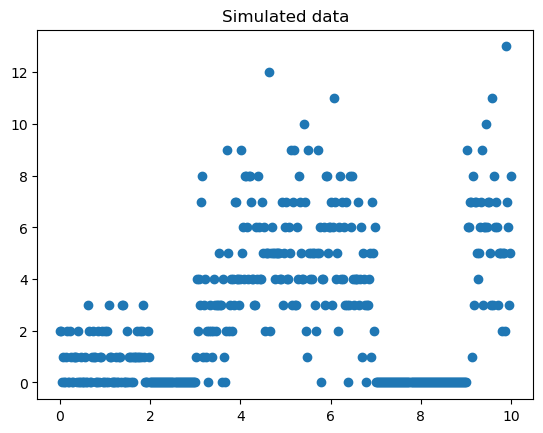

In [5]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

In [6]:
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)

kg = gpf.kernels.RBF(variance=5, lengthscales=2)

# initialise equally spaced inducing point locations
Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)
Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)

In [7]:
# model definition
m = OnOffSVGPPoiMC(Xtrain, Ytrain
              ,kernf=kf,kerng=kg
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,Zg = Zg, samples=100
             )

# make variance trainable
m.likelihood.variance.assign(0.01)
from gpflow import set_trainable
set_trainable(m.likelihood.variance, False)

In [8]:
N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)


In [9]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.05)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf
#logf = run_adam(m, 10)

In [10]:
%%time
logf = run_adam(m, 100000)

CPU times: user 13min 9s, sys: 19.7 s, total: 13min 29s
Wall time: 8min 9s


178.15636

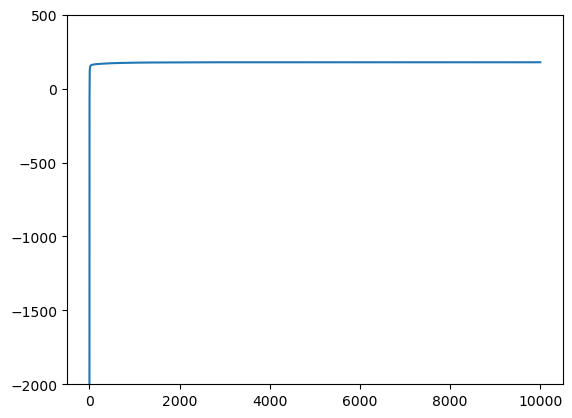

In [11]:
plt.plot(np.arange(len(logf)), logf)
plt.ylim((-2000),500)
logf[-1]

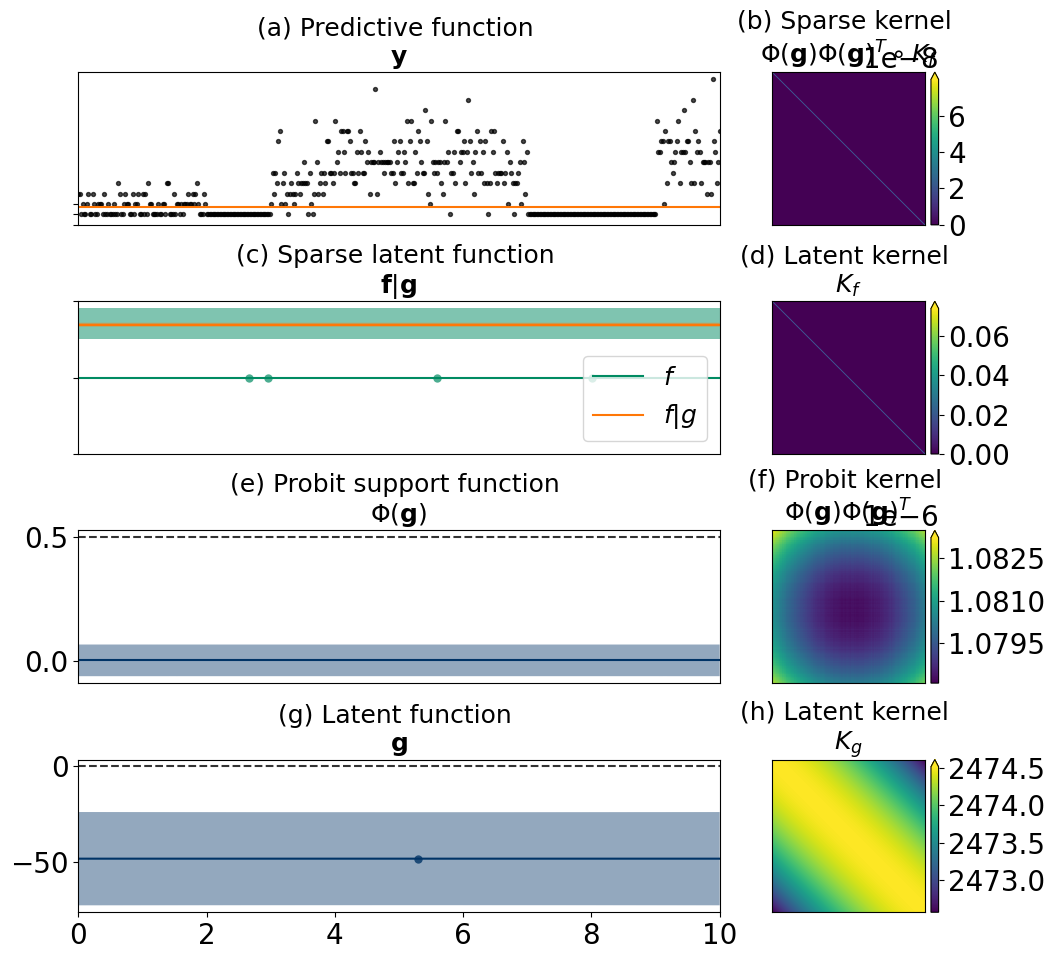

In [12]:
PlotOnOff1D(m, softplus=True)

In [13]:
# get prior KL
KL = m.build_prior_KL()

# get augmented functions
_, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(m.X)

data_shape = m.X.shape
u = tf.random.normal(shape=data_shape + (m.samples,))
w = tf.random.normal(shape=data_shape + (m.samples,))

# Expand dims to give the mean a sample dimension
g_mean_NDS = tf.expand_dims(gmean, -1)
g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
g_samples = g_mean_NDS + u * g_std_NDS

In [14]:
def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

phi_g_samples = normcdf(g_samples)

In [15]:
f_mean_NDS = tf.expand_dims(fmean, -1)
f_var_NDS = tf.expand_dims(fvar, -1)
f_std_NDS = tf.math.sqrt(f_var_NDS)
f_samples = f_mean_NDS * phi_g_samples + w * f_std_NDS * phi_g_samples

In [16]:
f_samples

<tf.Tensor: shape=(450, 1, 100), dtype=float32, numpy=
array([[[ 1.5118028e-04, -1.8666949e-04, -2.3696166e-06, ...,
          2.0489964e-05,  1.7980757e-04,  7.7835517e-05]],

       [[ 2.6040798e-04,  2.0115502e-04,  6.1569811e-04, ...,
          3.2198438e-04,  1.4424577e-04, -4.1565188e-04]],

       [[-1.8878707e-04, -9.4872084e-05, -1.8236018e-04, ...,
         -3.6473497e-04, -1.4497062e-04, -9.2080241e-05]],

       ...,

       [[ 1.1567211e-04,  2.4988051e-04,  9.0893052e-05, ...,
         -1.6603309e-04,  2.6669525e-04, -1.0179768e-04]],

       [[-4.6394058e-04,  2.1233385e-04,  2.1333697e-04, ...,
          4.4724386e-04,  5.0203915e-04, -1.7335355e-04]],

       [[ 5.4911096e-05, -3.0352126e-04, -4.0916519e-05, ...,
         -2.6896215e-04, -7.2211216e-05,  1.2002490e-04]]], dtype=float32)>

In [17]:
tf.reduce_max(tf.math.softplus(f_samples))

<tf.Tensor: shape=(), dtype=float32, numpy=0.7533288>

In [18]:
tf.reduce_max(f_samples)

<tf.Tensor: shape=(), dtype=float32, numpy=0.11694608>

In [19]:
m.trainable_variables

(<tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
 array([[-3.2248895 ],
        [-1.8212081 ],
        [-0.55870897],
        [ 2.6558077 ],
        [ 2.9564958 ],
        [ 5.596391  ],
        [ 8.005827  ],
        [10.765298  ],
        [11.67591   ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
 array([[-3164.7432  ],
        [-2325.234   ],
        [-1501.0576  ],
        [ -682.5424  ],
        [    5.291798],
        [  693.7237  ],
        [ 1511.8406  ],
        [ 2335.9912  ],
        [ 3175.4648  ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
 array([[-2.0809452e-09],
        [-1.7244302e-18],
        [ 2.1725870e-09],
        [-4.8491069e-15],
        [ 2.9940372e-15],
        [ 2.3160803e-16],
        [-3.9837632e-21],
        [-1.4700632e-07],
        [ 3.0057665e-05]], dtype=float32)>,
 <tf.Variable 'softplus:0' shape=(9, 1) dtype=float32, numpy=
 array([[-1.1660762],
        [-1.1660752

In [20]:
Zg

array([[1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.],
       [9.]], dtype=float32)

In [21]:
_gfmean,_gfvar,_,_fmean,_fvar,_gmean,_gvar,_pgmean,_pgvar = m.predict_onoffgp(m.X)

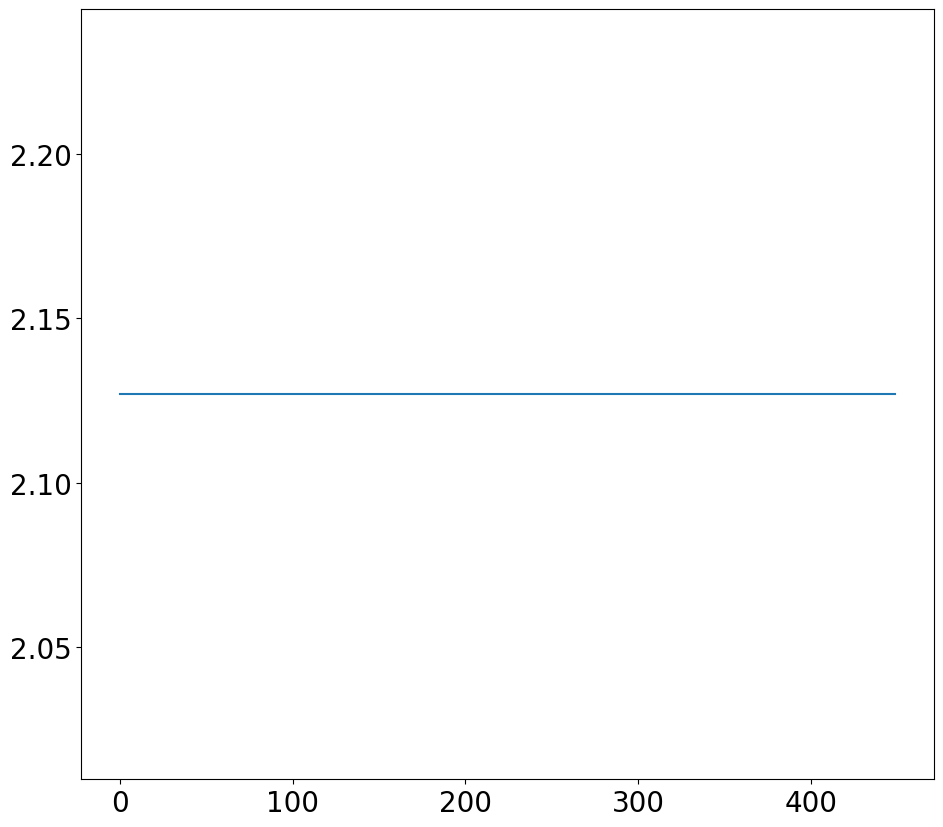

In [22]:
plt.plot(np.arange(len(_gfmean)),tf.math.softplus(_gfmean+2))